<a href="https://colab.research.google.com/github/Voyageran/StartNN/blob/main/linear_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/content/notebooks/colabInstallPackage")

!cp -av '/content/gdrive/MyDrive/Colab Notebooks/d2l' '/content/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'/content/gdrive/MyDrive/Colab Notebooks/d2l/paddle.py' -> '/content/d2l/paddle.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/mxnet.py' -> '/content/d2l/mxnet.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/tensorflow.py' -> '/content/d2l/tensorflow.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/torch.py' -> '/content/d2l/torch.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__init__.py' -> '/content/d2l/__init__.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/mxnet.cpython-310.pyc' -> '/content/d2l/__pycache__/mxnet.cpython-310.pyc'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/__init__.cpython-310.pyc' -> '/content/d2l/__pycache__/__init__.cpython-310.pyc'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/torch.cpython-310.pyc' -> '/content/d2l/__pycache__/torch.cpython-310.pyc'
'/content/gdrive/MyDrive/Colab Notebook

# **线性神经网络**

## **线性回归**

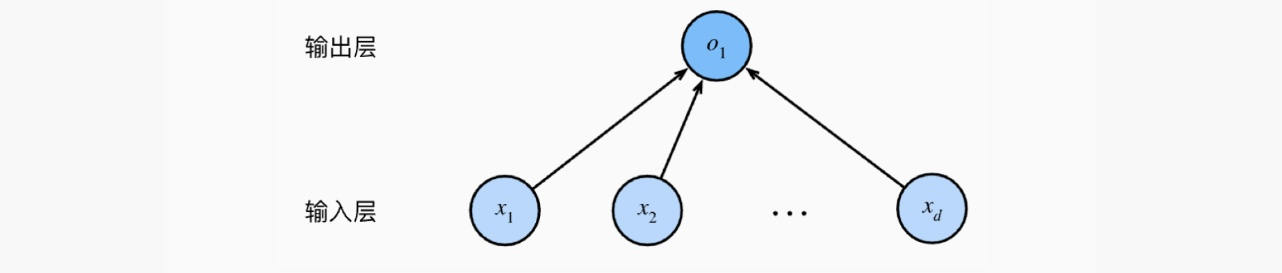

### **从零开始实现**

In [68]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

Set $\mathbf{w} = [2, -3.4]^{T}$, $b = 4.2$, noise term $ϵ$,

构造数据集
$$
 \mathbf{y} = \mathbf{X}\mathbf{w} + b + ϵ
$$

In [69]:
def synthetic_data(w,b,num_examples):
  """ generate y = Xw + b + eps"""
  X = torch.normal(0,1,(num_examples, len(w)))
  y = torch.matmul(X,w) + b #broadcast,
  # torch.matmul():If the first argument is 2-dimensional and the second argument is 1-dimensional, the matrix-vector product is returned
  y += torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1,1)) #转成列向量，因为前面计算会自动变成行向量
  #reshape中-1代表n，所以如果换成(1,-1)就是行向量

In [70]:
import torch
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [71]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 1.0299, -0.7129]) 
label: tensor([8.6820])


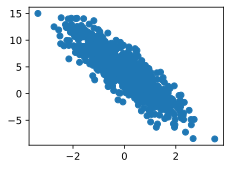

In [72]:
d2l.set_figsize()
# feature 2 and y
d2l.plt.scatter(features[:,1].detach().numpy(), #先detach移出计算图，才能变numpy
                labels.detach().numpy())


2D没意思，看下3D哈。

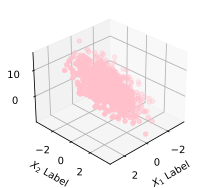

In [73]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize = (6,3))
ax = fig.add_subplot(projection='3d')

ax.scatter(features[:,0], features[:,1], labels, c ='pink')

ax.set_xlabel('$X_1$ Label')
ax.set_ylabel('$X_2$ Label')
ax.set_zlabel('Labels')

ax.view_init(elev=30,azim = 45) #elev设定仰角，azim左右动
plt.show()

**Model**

In [74]:
def linreg(X, w, b):
  """linear regression"""
  return torch.matmul(X, w) + b

In [75]:
# Initialize model parameters
w = torch.normal(0, 0.01, size = (2,1), requires_grad = True)
b = torch.zeros(1, requires_grad=True)

**Loss Function**

In [76]:
def squared_loss(y_hat, y): #没有算均值呢，所以后面除以总数放在了优化算法func里
  """l_i = 1/2 (yhat_i-y_i)^2"""
  return (y.reshape(y_hat.shape) - y_hat)**2 / 2 #reshape()来防止行列向量的不一致

我们为什么没有写sum呢，因为输入的时候我们就把samples的yhat给sum了。还记得basic里面学梯度的那一部分吗。这里唯一缺的是 1/n。像普通的均值平方要乘以1/n的，但现在我们要留到后面批量梯度下降用，在优化算法里scale。

**Optimization Algorthim**

显然，用最小二乘得到的线性回归最优weight是$\mathbf{w}^{\ast} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$，但是不是所有的问题都有解析解。我们现在用优化算法来解这个最优值。

我们用小批量随机梯度下降Mini-Batch Stochastic Gradient Descent (MBSGD)来minimize loss function to 优化parameters。


1.   定义一个Mini-Batch generator
2.   定义一个MBSGD函数



Let $\mathbf{x}, \mathbf{w} \in \mathbb{R}^{d}$, $\alpha$ is step/learning rate, $L(\mathbf{w},b)$ is the corresponding loss function, $|B|$ is the size of batch $B$.

For each sample, regression function is
$$
\hat{y} = \mathbf{w}^{T}\mathbf{x} + b
$$

For sample $i$, the loss function we used is
$$
l_{i}(\mathbf{w},b) = \frac{1}{2} (\hat{y}_{i} - y_{i})^2
$$
Then, the loss function of $n$ samples in the training set is (mean square loss function)
$$
L(\mathbf{w},b) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{2}(\hat{y}_{i} - y_{i})^2 = \frac{1}{2n} \sum_{i=1}^{m} (\mathbf{w}^{T}\mathbf{x} + b - y_{i})^2
$$

Our goal:
$$
\mathbf{w}^{\ast}, b^{\ast} = argmin_{\mathbf{w}, b}  L(\mathbf{w}, b)
$$

Set $\boldsymbol{\theta} = \{ \mathbf{w}, b\}$. Then the iteration equation is
$$
\theta_{j} := \theta_{j} - \frac{\alpha}{|B|} \sum_{i \in B} \frac{∂ l_{i}  (\boldsymbol{\theta})}{∂ \theta_{j}}
$$
Where $j=1,2$, $|B|$ is the size of batch $B$.

For $\mathbf{w} \in \mathbb{R}^{d}$, the iteration equation is
$$
\mathbf{w}^{(t)} = \mathbf{w}^{(t-1)} - \mathbf{x}_{i}\frac{\alpha}{|B|} \sum_{i \in B} \mathbf(\mathbf{w}^T \mathbf{x}_{i} + b- y_i)
$$
注意，我们现在更新的是$\mathbf{w}$而不是$\mathbf{w}^{T}$， 所以求导是行向量的转置。

For bias $b$, we have
$$
b^{(t)} = b^{(t-1)} - \frac{\alpha}{|B|} \sum_{i \in B} (\mathbf{w}^T \mathbf{x}_{i} + b - y_i)
$$

<!-- 求个偏导，
\begin{equation}
  \begin{aligned}
    \frac{∂ L(\boldsymbol{\theta})}{∂ \theta_{j}} &= \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) (\frac{}{\partial w_j})
  \end{aligned}
\end{equation} -->

In [77]:
# input:批量大小、特征矩阵和标签向量，generate: batch_size的小批量
def data_iter(batch_size, features, labels):
  num_examples = len(features) #sample个数
  indices = list(range(num_examples)) # Remember to add list()
  random.shuffle(indices) #为了都抽得到
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(
        indices[i: min(i+batch_size, num_examples)] # 取min是为了防止溢出，最后一个batch没取满无大碍
    )
    yield features[batch_indices], labels[batch_indices]

In [78]:
# test data_iter()
batch_size = 10

# for X, y in data_iter(batch_size, features, labels):
#   print(X, '\n', y)

Remark:
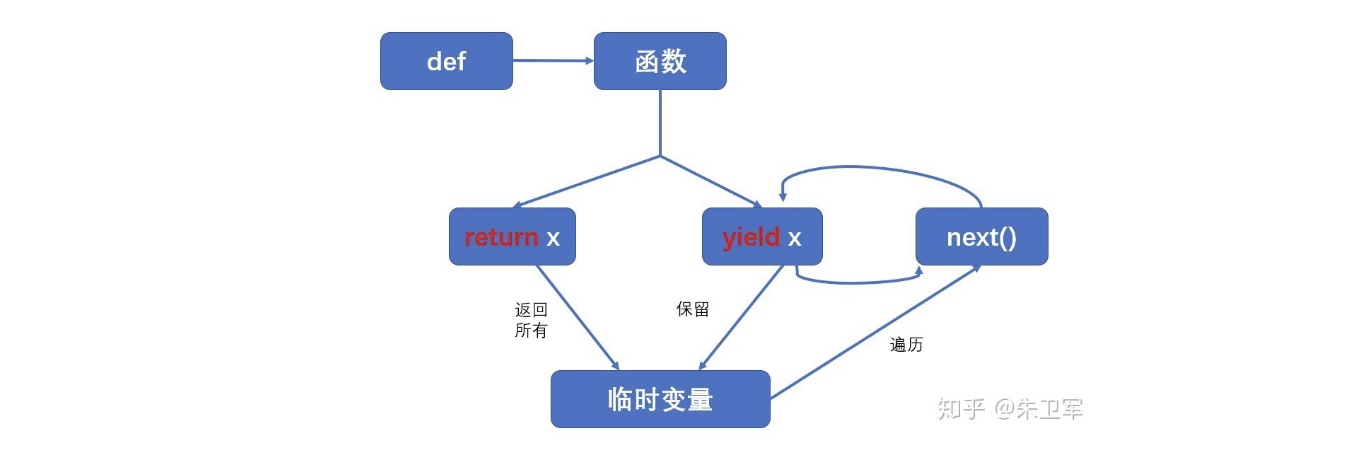

In [79]:
#e.g.,
def fab(max):
  n, a, b = 0, 0, 1
  while n < max:
    yield b
    a, b = b, a+b
    n += 1

for n in fab(5):
    print(n)

1
1
2
3
5


`lr` == learning rate (deep learning) == step (optimization)

In [80]:
# Define SGD
def sgd(params, lr, batch_size):
  """Mini-batch SGD"""
  with torch.no_grad(): #更新的时候不参与梯度计算
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()  #注意梯度清零

Training

In [81]:
# setting hyperparameters
lr = 0.03
num_epochs = 3
net = linreg #model
loss = squared_loss
batch_size = 10

#
for epoch in range(num_epochs): # 扫num_epochs次
  for X, y in data_iter(batch_size, features, labels):
  # 每次拿出一个批量的X和y
    l = loss(net(X, w, b), y)
    l.sum().backward()
    sgd([w,b], lr, batch_size) #batch_size 有不被整除的可能，这里不够严谨
  with torch.no_grad(): #看一下循环的进度（这里不需要求梯度）
    train_l = loss(net(X, w, b), y)
    print(f'epoch {epoch + 1}, loss{float(train_l.mean()):f}')

epoch 1, loss0.035903
epoch 2, loss0.000130
epoch 3, loss0.000086


In [82]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0003, 0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0009], grad_fn=<RsubBackward1>)


### **用dl framework简洁实现线性回归**

In [93]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

# generate true data
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

好了，我们用这个高级模块再来一遍一模一样的步骤。

In [94]:
# 调用框架已有的API读取数据
def load_array(data_arrays, batch_size, is_train=True):
  """construct a PyTorch data generator """
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-0.5252, -0.1136],
         [-1.1292, -0.1334],
         [ 0.4793, -0.3918],
         [ 0.5341, -0.4909],
         [-0.9369, -2.8841],
         [ 0.8924,  0.9913],
         [-0.3179, -0.5269],
         [ 1.0571, -0.7560],
         [-0.7384,  0.2113],
         [-0.0485, -0.0201]]),
 tensor([[ 3.5445],
         [ 2.3857],
         [ 6.4955],
         [ 6.9428],
         [12.1215],
         [ 2.6180],
         [ 5.3582],
         [ 8.8873],
         [ 1.9982],
         [ 4.1889]])]

- `TensorDataset` 通过沿着第一个维度索引两个张量来恢复每个样本。
- `TensorDataset` 中的参数必须是 tensor

```
class torch.utils.data.TensorDataset(data_tensor, target_tensor)
```

- `DataLoader`就是用来包装所使用的数据，每次抛出一批数据。

```
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
```




- ‘*’就是正常的tuple/list/set解包操作

**模型直接使用框架预定义好的layer**

In [98]:
from torch import nn

# nn.Sequential()是个容器，可以想成一个list里面有很多层
# nn.Linear(2,1)中2是input dim， 1是output dim
net = nn.Sequential(nn.Linear(2,1))
net

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

**Initial parameters**

In [99]:
# net[0]访问Sequential()中第0层（线性层）
# Remember PyTorch中 '_' 代表重写
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0) #bias=0

tensor([0.])

**均方误差**

In [100]:
loss = nn.MSELoss()

**实例化SGD**

In [101]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.03)
#SGD函数里面已经有torch.no_grad()了
# 所以后面训练的时候，打印过程不需要手动去除求梯度

**Train**

In [102]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward() # PyTorch已经给做了sum，不用再sum一遍了
        trainer.step() #step()用来进行模型更新
    l = loss(net(features), labels) #记录过程
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000226
epoch 2, loss 0.000108
epoch 3, loss 0.000109


In [103]:
print('w的估计误差：', true_w - w.reshape(true_w.shape))
print('b的估计误差：', true_b - b)

w的估计误差： tensor([0.0003, 0.0003], grad_fn=<SubBackward0>)
b的估计误差： tensor([0.0009], grad_fn=<RsubBackward1>)


### **Exercise**



1.   如果将小批量的总损失替换为小批量损失的平均值，需要如何更改学习率？

 $lr = lr * |B|$
 原本在优化函数中要除的，在loss function里面除掉了，那学习率就乘回去

2.   如何访问线性回归的梯度？

Add `print(net[0].weight.grad)`
```
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward() # PyTorch已经给做了sum，不用再sum一遍了
        print(net[0].weight.grad)
        trainer.step() #step()用来进行模型更新
    l = loss(net(features), labels) #记录过程
    print(f'epoch {epoch + 1}, loss {l:f}')
```



In [ ]:
# num_epochs = 3
# for epoch in range(num_epochs):
#     for X, y in data_iter:
#         l = loss(net(X) ,y)
#         trainer.zero_grad()
#         l.backward() # PyTorch已经给做了sum，不用再sum一遍了
#         print(net[0].weight.grad)
#         trainer.step() #step()用来进行模型更新
#     l = loss(net(features), labels) #记录过程
#     print(f'epoch {epoch + 1}, loss {l:f}')

## **SoftMax**

用图表示回归和分类

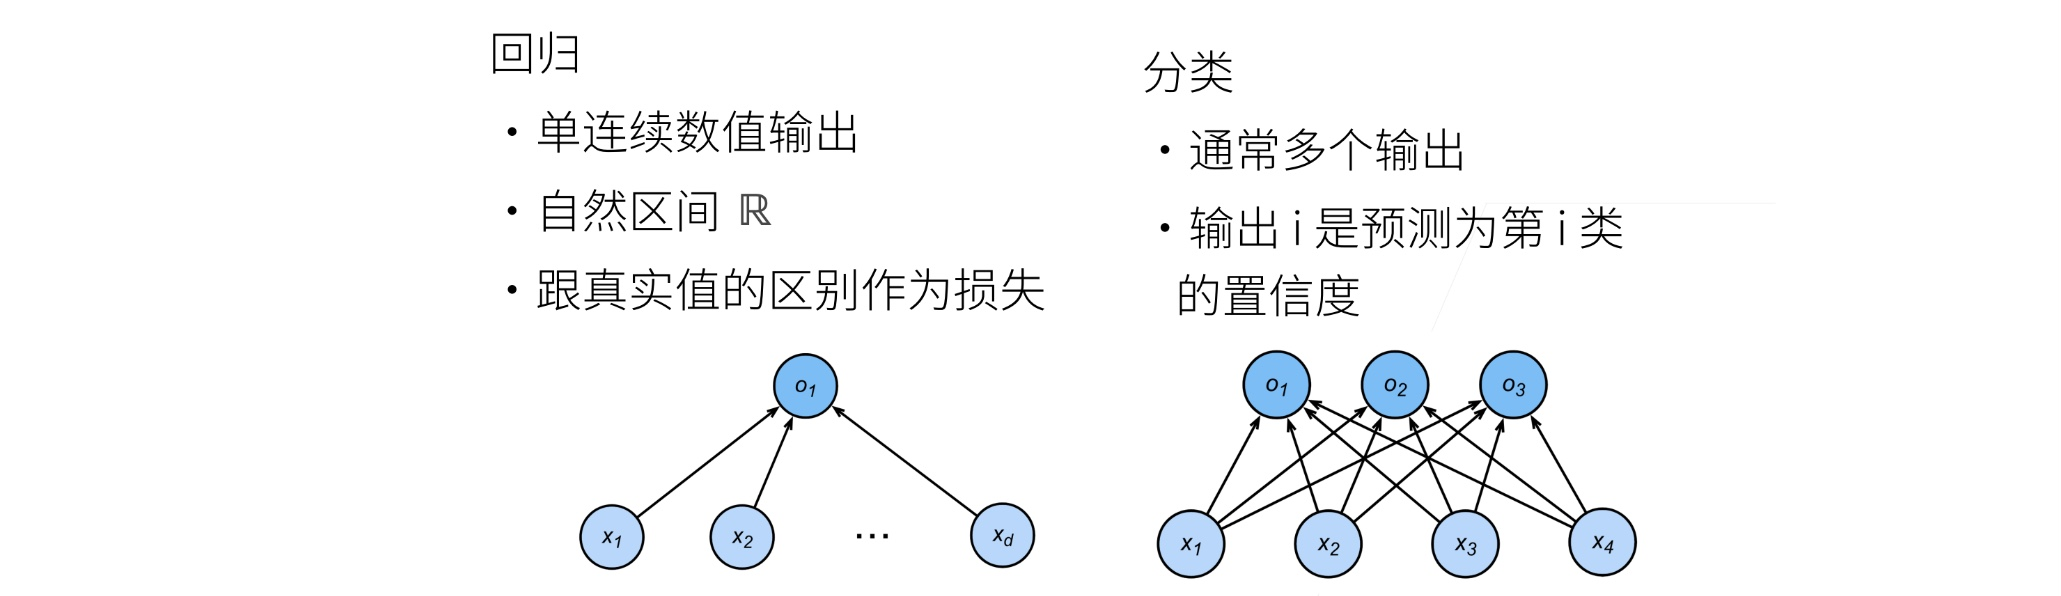

Let $\mathbf{y} = (y_1,...,y_n)^T$,  where $i \in [n]$.
<!--
- Encode for classes
$$
y_i =
\begin{cases}
  1 & \text{if } i=y \\
  0 & \text{ otherwise }
\end{cases}
$$ -->
<!-- - $\hat{y} = \underset{i}{\mathrm{argmax}}$ $ -->

- output probabilities ($p_i \geq 0$, $\sum_i p_{i} = 1$)

\begin{equation}
  \hat{\mathbf{y}} = softmax(\mathbf{o})
\end{equation}

\begin{equation}
  \hat{y}_{i} = \frac{exp(o_{i})}{\sum_{k}exp(o_{k})}
\end{equation}
- Probabilities $\hat{\mathbf{y}}$ and $\mathbf{y}$ as loss.

**Cross-Entropy**
- 衡量两个概率之间的区别
- $H(\mathbf{p},\mathbf{q}) = -\sum_{i}p_{i}log(q_{i})$

**More about entropy**

熵的目的是为了寻找一种高效且无损的encode information的方法。

怎么算高效且无损呢？

高效：以编码后数据的平均长度衡量高效性，平均长度越小越高效

无损：编码后不能有原始信息的丢失。

熵：服从某一特定概率分布事件的无损编码事件信息的最小平均编码长度

熵公式的推断：

先看个例子，假设一个信息有N种可能，且状态是等可能性的，即$P(i) = \frac{1}{N}$。

则我们至少需要$log_2 N$ bit 来编码。

所以编码该信息最小长度
\begin{equation}
    log_2 N = -log_2 \frac{1}{N} = -log_2 P
\end{equation}

计算熵是计算平均的最小长度（离散），所以
\begin{equation}
    Entropy = - \sum_i P(i) log_2 P(i)
\end{equation}
其中，$P(i)$ 是第 i 个信息状态的可能性。

Suppose the entropy value is large (i.e. the average length of the encoding is long). In that case, there are more possible states in this information, which means there is a relatively large degree of uncertainty/ confusion.

另外，当收到一个不常见的信息时，它比常见的信息含有更多的信息量。比如，当我们接收到明天是下雨的概率是10$\%$的时候，

连续变量$x$的概率分布 $P(x)$，熵的公式：
\begin{equation}
    Entropy = - \int P(x) log_2 P(x) dx
\end{equation}

<!-- Rewrite equations \ref{eq.entropy_discrete} and \ref{eq.entropy_continue} by expectation:
\begin{equation}
    H(P) = Entropy = \mathbb{E}_{x \sim P} [-log P(x)]
\end{equation} -->

### **从零开始**

### **nn框架实现**